#VER QUÉ DATOS DE ACTIVOS-PASIVOS-CR SON MÁS RELEVANTES
Alicia Amores Sánchez

##Importación de paquetes y carga de datos

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import missingno
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, average_precision_score
from sklearn.ensemble import RandomForestClassifier, IsolationForest

Carga de datos

In [2]:
# Importar dataset
datos = pd.read_excel('GACELAS-Datos.xlsx')
ratios = pd.read_excel('GACELAS-Ratios_Empleados.xlsx')
subvenciones = pd.read_excel('Subvenciones.xlsx')
CR=pd.read_excel('GACELAS-Activo+Pasivo+CR.xlsx', sheet_name="CR")
activo=pd.read_excel('GACELAS-Activo+Pasivo+CR.xlsx', sheet_name="Activo")
pasivo=pd.read_excel('GACELAS-Activo+Pasivo+CR.xlsx', sheet_name="Pasivo")

##**ABUELOS**

De los dataframes de **Activo** y **Pasivo** eliminamos todas las columnas menos las de totales (TOT_ACTIVO_A_B_YYYY, TOT_PN_PASIVO_YYYY, RES_EJERC_YYYY)

In [ ]:
activo_pasivo_CR=activo.merge(pasivo, on='ID').merge(CR, on='ID')

In [ ]:
data = {"ID":activo_pasivo_CR['ID'],
            "TOT_ACTIVO_A_B_2020": activo_pasivo_CR['TOT_ACTIVO_A_B_2020'],
            "TOT_ACTIVO_A_B_2019": activo_pasivo_CR['TOT_ACTIVO_A_B_2019'],
            "TOT_ACTIVO_A_B_2018": activo_pasivo_CR['TOT_ACTIVO_A_B_2018'],
            "TOT_ACTIVO_A_B_2017": activo_pasivo_CR['TOT_ACTIVO_A_B_2017'],
            "TOT_ACTIVO_A_B_2016": activo['TOT_ACTIVO_A_B_2016'],
            "TOT_PN_PASIVO_2020": activo_pasivo_CR['TOT_PN_PASIVO_2020'],
            "TOT_PN_PASIVO_2019": activo_pasivo_CR['TOT_PN_PASIVO_2019'],
            "TOT_PN_PASIVO_2018": activo_pasivo_CR['TOT_PN_PASIVO_2018'],
            "TOT_PN_PASIVO_2017": activo_pasivo_CR['TOT_PN_PASIVO_2017'],
            "TOT_PN_PASIVO_2016": activo_pasivo_CR['TOT_PN_PASIVO_2016'],
            "RES_EJERC_2020": activo_pasivo_CR['RES_EJERC_2020'],
            "RES_EJERC_2019": activo_pasivo_CR['RES_EJERC_2019'],
            "RES_EJERC_2018": activo_pasivo_CR['RES_EJERC_2018'],
            "RES_EJERC_2017": activo_pasivo_CR['RES_EJERC_2017'],
            "RES_EJERC_2016": activo_pasivo_CR['RES_EJERC_2016']
           }

In [ ]:
totales=pd.DataFrame(data)

In [ ]:
#vemos si hay registros duplicados
if datos.duplicated().any():
  print('datos yes')
if ratios.duplicated().any():
  print('ratios yes')
if subvenciones.duplicated().any():
  print('subvenciones yes')
if totales.duplicated().any():
  print('totales yes')

subvenciones yes


In [ ]:
#eliminamos los duplicados
subvenciones=subvenciones.drop_duplicates()

Juntamos todos los datasets por el ID de la empresa

In [ ]:
df = datos.merge(ratios,on='ID').merge(subvenciones,on='ID').merge(totales, on='ID')

In [ ]:
df.head()

,ID,CNAE,CNAE_DESCRIPCION,IMPORT_EXPORT,ULT_ACTOMERCANTIL,TAM_EMPRESA,Estado,ACC_EXTRAN,ACC_EMPRESA,NUMACCIONISTAS,...,TOT_PN_PASIVO_2020,TOT_PN_PASIVO_2019,TOT_PN_PASIVO_2018,TOT_PN_PASIVO_2017,TOT_PN_PASIVO_2016,RES_EJERC_2020,RES_EJERC_2019,RES_EJERC_2018,RES_EJERC_2017,RES_EJERC_2016
0,100017,7219,Otra investigación y desarrollo experimental e...,Nada,2020-12-14 01:00:00,Microempresa,Viva,NaN,NaN,NaN,...,1047.0,1139.0,1322.0,46.0,59.0,-20,-100,-81,-14,-3
1,100017,7219,Otra investigación y desarrollo experimental e...,Nada,2020-12-14 01:00:00,Microempresa,Viva,NaN,NaN,NaN,...,1047.0,1139.0,1322.0,46.0,59.0,-20,-100,-81,-14,-3
2,100017,7219,Otra investigación y desarrollo experimental e...,Nada,2020-12-14 01:00:00,Microempresa,Viva,NaN,NaN,NaN,...,1047.0,1139.0,1322.0,46.0,59.0,-20,-100,-81,-14,-3
3,100020,2822,Fabricación de maquinaria de elevación y manip...,Nada,2019-02-04 01:00:00,Pequeña,Viva,NaN,NaN,1.0,...,2537.0,2357.0,1186.0,NaN,NaN,973,1004,593,0,0
4,100020,2822,Fabricación de maquinaria de elevación y manip...,Nada,2019-02-04 01:00:00,Pequeña,Viva,NaN,NaN,1.0,...,2537.0,2357.0,1186.0,NaN,NaN,973,1004,593,0,0


Vemos si hay registros duplicados para eliminarlos

In [ ]:
if df.duplicated().any():
  print('yes')

###Cambiar de años naturales a años de vida de la startup

Antes de hacer modificaciones, vamos a eliminar las columnas calculadas que no deben estar en los datos para realizar el modelo de clasificación de empresas de alto crecimiento: VENTAS_FINAL, NUM_BALANCES, BalYYYY, VENTAS_YYYY, CRECY1Y1Y2Y2 y GACELAY1Y1Y2Y2.

In [ ]:
df.drop(columns=['VENTAS_FINAL', 'CREC20192020', 'CREC20182019', 'CREC20172018', 'CREC20162017', 'GACELA20192020', 'GACELA20182019', 
                 'GACELA20172018', 'GACELA20162017'], axis=1, inplace=True)

Hay varias columnas con datos de años naturales (2016-2020), estos años, para que tengan más sentido, los vamos a pasar a años de balances realizados por la empresa. Por lo que tendremos el 1 (primer balance), 2 (segundo balance)...

Lista con los nombres de las nuevas columnas:

In [ ]:
nuevas_columnas=[]
columnas=list(df.columns)
for col in columnas:
  if '2016' in col:
    col1=col.replace('2016', '1')
    nuevas_columnas.append(col1)
  if '2017' in col:
    col2=col.replace('2017', '2')
    nuevas_columnas.append(col2)
  if '2018' in col:
    col3=col.replace('2018', '3')
    nuevas_columnas.append(col3)
  if '2019' in col:
    col4=col.replace('2019', '4')
    nuevas_columnas.append(col4)
  if '2020' in col:
    col5=col.replace('2020', '5')
    nuevas_columnas.append(col5)


Añadimos las nuevas columnas al dataset

In [ ]:
for nc in nuevas_columnas:
  df[nc]=np.nan

Para todas las empresas cuyo primer balance es en el año 2016, copiaremos los datos de cada año en las columnas de su año relativo correspondiente (2016=1, 2017=2...)

In [ ]:
for i in range(0,len(df)):
  if df['Bal2016'][i]==1:
    for col in list(df.columns):
      if '2016' in col:
        col1=col.replace('2016', '1')
        df[col1][i]=df[col][i]
      if '2017' in col:
        col2=col.replace('2017', '2')
        df[col2][i]=df[col][i]
      if '2018' in col:
        col3=col.replace('2018', '3')
        df[col3][i]=df[col][i]
      if '2019' in col:
        col4=col.replace('2019', '4')
        df[col4][i]=df[col][i]
      if '2020' in col:
        col5=col.replace('2020', '5')
        df[col5][i]=df[col][i]
  elif df['Bal2017'][i]==1:
    for col in list(df.columns):
      if '2017' in col:
        col2=col.replace('2017', '1')
        df[col2][i]=df[col][i]
      if '2018' in col:
        col3=col.replace('2018', '2')
        df[col3][i]=df[col][i]
      if '2019' in col:
        col4=col.replace('2019', '3')
        df[col4][i]=df[col][i]
      if '2020' in col:
        col5=col.replace('2020', '4')
        df[col5][i]=df[col][i]
  elif df['Bal2018'][i]==1:
    for col in list(df.columns):
      if '2018' in col:
        col3=col.replace('2018', '1')
        df[col3][i]=df[col][i]
      if '2019' in col:
        col4=col.replace('2019', '2')
        df[col4][i]=df[col][i]
      if '2020' in col:
        col5=col.replace('2020', '3')
        df[col5][i]=df[col][i]
  elif df['Bal2019'][i]==1:
    for col in list(df.columns):
      if '2019' in col:
        col4=col.replace('2019', '1')
        df[col4][i]=df[col][i]
      if '2020' in col:
        col5=col.replace('2020', '2')
        df[col5][i]=df[col][i]
  elif df['Bal2020'][i]==1:
    for col in list(df.columns):
      if '2020' in col:
        col5=col.replace('2020', '1')
        df[col5][i]=df[col][i]

<ipython-input-14-c3240c74144c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col5][i]=df[col][i]
<ipython-input-14-c3240c74144c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col4][i]=df[col][i]
<ipython-input-14-c3240c74144c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col3][i]=df[col][i]
<ipython-input-14-c3240c74144c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Eliminamos las columnas de años naturales

In [ ]:
eliminar=[]

for col in df.columns:
  if '2016' in col:
    eliminar.append(col)
  elif '2017' in col:
    eliminar.append(col)
  elif '2018' in col:
    eliminar.append(col)
  elif '2019' in col:
    eliminar.append(col)
  elif '2020' in col:
    eliminar.append(col) 

df.drop(columns=eliminar, axis=1, inplace=True)

Las startups con más de 3 años de vida las vamos a separar en registros de 3. Es decir, si una empresa tiene 4 años de vida, vamos a tener un registro con los años 1, 2 y 3; y otro registro con los años 2, 3 y 4. 

Para ello hacemos 2 nuevos datasets, uno de 4 años y otro de 5 y realizamos las replicas sobre estos dos nuevos datasets para unirlos al original de forma posterior

In [ ]:
#df_4años=df[df['NUM_BALANCES']==4]
#df_5años1=df[df['NUM_BALANCES']==5]
df_5años2=df[df['NUM_BALANCES']==5]

In [ ]:
"""
eliminar=[]
for col in df_4años:
  if '1' in col:
    eliminar.append(col)
  if '5' in col:
    eliminar.append(col)

df_4años.drop(columns=eliminar, axis=1, inplace=True)

rename_cols={}
for col in df_4años:
  if '2' in col:
    col2=col.replace('2', '1')
    rename_cols[col]=col2
  if '3' in col:
    col3=col.replace('3', '2')
    rename_cols[col]=col3
  if '4' in col:
    col4=col.replace('4', '3')
    rename_cols[col]=col4

df_4años=df_4años.rename(columns=rename_cols)
"""

"\neliminar=[]\nfor col in df_4años:\n  if '1' in col:\n    eliminar.append(col)\n  if '5' in col:\n    eliminar.append(col)\n\ndf_4años.drop(columns=eliminar, axis=1, inplace=True)\n\nrename_cols={}\nfor col in df_4años:\n  if '2' in col:\n    col2=col.replace('2', '1')\n    rename_cols[col]=col2\n  if '3' in col:\n    col3=col.replace('3', '2')\n    rename_cols[col]=col3\n  if '4' in col:\n    col4=col.replace('4', '3')\n    rename_cols[col]=col4\n\ndf_4años=df_4años.rename(columns=rename_cols)\n"

Hay dos datasets de 5 años. El pimero será del año 2 al 4 y el segundo será del año 3 al 5

In [ ]:
"""
eliminar=[]
for col in df_5años1:
  if '1' in col or '5' in col:
    eliminar.append(col)
  

df_5años1.drop(columns=eliminar, axis=1, inplace=True)

rename_cols={}
for col in df_5años1:
  if '2' in col:
    col2=col.replace('2', '1')
    rename_cols[col]=col2
  if '3' in col:
    col3=col.replace('3', '2')
    rename_cols[col]=col3
  if '4' in col:
    col4=col.replace('4', '3')
    rename_cols[col]=col4

df_5años1=df_5años1.rename(columns=rename_cols)

"""
#5ños 2

eliminar=[]
for col in df_5años2:
  if '1' in col:
    eliminar.append(col)

df_5años2.drop(columns=eliminar, axis=1, inplace=True)

rename_cols={}
for col in df_5años2:
  if '2' in col:
    col1=col.replace('2', '1')
    rename_cols[col]=col1
  if '3' in col:
    col2=col.replace('3', '2')
    rename_cols[col]=col2
  if '4' in col:
    col3=col.replace('4', '3')
    rename_cols[col]=col3
  if '5' in col:
    col4=col.replace('5', '4')
    rename_cols[col]=col4

df_5años2=df_5años2.rename(columns=rename_cols)


<ipython-input-18-7c04abf18ee1>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5años2.drop(columns=eliminar, axis=1, inplace=True)


Unimos los 3 datasets y eliminamos los años 4 y 5.

In [ ]:
#"""
#primero eliminamos los años 5 del dataset original
eliminar=[]
for col in df:
  if '5' in col:
    eliminar.append(col)
df.drop(columns=eliminar, axis=1, inplace=True)



In [ ]:
#"""
#Unimos los datasets
frames = [df, df_5años2]
df2 = pd.concat(frames)
#"""

In [ ]:
df2.head()

,ID,CNAE,CNAE_DESCRIPCION,IMPORT_EXPORT,ULT_ACTOMERCANTIL,TAM_EMPRESA,Estado,ACC_EXTRAN,ACC_EMPRESA,NUMACCIONISTAS,...,TOT_ACTIVO_A_B_2,TOT_ACTIVO_A_B_1,TOT_PN_PASIVO_4,TOT_PN_PASIVO_3,TOT_PN_PASIVO_2,TOT_PN_PASIVO_1,RES_EJERC_4,RES_EJERC_3,RES_EJERC_2,RES_EJERC_1
0,100017,7219,Otra investigación y desarrollo experimental e...,Nada,2020-12-14 01:00:00,Microempresa,Viva,NaN,NaN,NaN,...,46.0,59.0,1139.0,1322.0,46.0,59.0,-100.0,-81.0,-14.0,-3.0
1,100017,7219,Otra investigación y desarrollo experimental e...,Nada,2020-12-14 01:00:00,Microempresa,Viva,NaN,NaN,NaN,...,46.0,59.0,1139.0,1322.0,46.0,59.0,-100.0,-81.0,-14.0,-3.0
2,100017,7219,Otra investigación y desarrollo experimental e...,Nada,2020-12-14 01:00:00,Microempresa,Viva,NaN,NaN,NaN,...,46.0,59.0,1139.0,1322.0,46.0,59.0,-100.0,-81.0,-14.0,-3.0
3,100020,2822,Fabricación de maquinaria de elevación y manip...,Nada,2019-02-04 01:00:00,Pequeña,Viva,NaN,NaN,1.0,...,2357.0,1186.0,NaN,2537.0,2357.0,1186.0,NaN,973.0,1004.0,593.0
4,100020,2822,Fabricación de maquinaria de elevación y manip...,Nada,2019-02-04 01:00:00,Pequeña,Viva,NaN,NaN,1.0,...,2357.0,1186.0,NaN,2537.0,2357.0,1186.0,NaN,973.0,1004.0,593.0


In [ ]:
#vemos si hay registros duplicados
if df2.duplicated().any():
  print('yes')


Además de lo anterior, los datos económicos (activo, pasivo y CR) hay que ponerlos de forma evolutiva, es decir, en porcentajes de diferencia respecto a los años anteriores. 

Para eso, primero creamos nuevas columnas donde añadir esos datos y dichas columnas serán la diferencia en porcentaje del año, respecto al anterior

In [ ]:
#Activo
df2['diff_activo_12']=(df2['TOT_ACTIVO_A_B_2']/df2['TOT_ACTIVO_A_B_1'])-1
df2['diff_activo_23']=(df2['TOT_ACTIVO_A_B_3']/df2['TOT_ACTIVO_A_B_2'])-1
df2['diff_activo_34']=(df2['TOT_ACTIVO_A_B_4']/df2['TOT_ACTIVO_A_B_3'])-1

#Pasivo
df2['diff_pasivo_12']=(df2['TOT_PN_PASIVO_2']/df2['TOT_PN_PASIVO_1'])-1
df2['diff_pasivo_23']=(df2['TOT_PN_PASIVO_3']/df2['TOT_PN_PASIVO_2'])-1
df2['diff_pasivo_34']=(df2['TOT_PN_PASIVO_4']/df2['TOT_PN_PASIVO_3'])-1

#CR
df2['diff_RES_EJERC_12']=(df2['RES_EJERC_2']/df2['RES_EJERC_1'])-1
df2['diff_RES_EJER_23']=(df2['RES_EJERC_3']/df2['RES_EJERC_2'])-1
df2['diff_RES_EJER_34']=(df2['RES_EJERC_4']/df2['RES_EJERC_3'])-1


Vemos si hay mayor correlacion con los valores en diferencia o enteros

In [ ]:
corr = df2.corr(method='pearson')
corr[['ALTO_CRECIMIENTO']].sort_values(by = 'ALTO_CRECIMIENTO',ascending = False)\
.style.background_gradient()

<ipython-input-24-97b67fcd29de>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df2.corr(method='pearson')


,ALTO_CRECIMIENTO
ALTO_CRECIMIENTO,1.000000
GACELA_CALCULADO,0.256052
NUM_BALANCES,0.185418
diff_RES_EJER_34,0.168690
diff_activo_34,0.134070
diff_pasivo_34,0.134069
NUMACCIONISTAS,0.111473
EMP_4,0.103240
ACC_EMPRESA,0.101401
AÑO CONCESION,0.060106


Como se puede observar la correlación es mayor con las diferencias que con los valores absolutos, por lo que se van a eliminar los valores absolutos exceptuando el 1. 

In [ ]:
eliminar=[ 'TOT_ACTIVO_A_B_2', 'TOT_ACTIVO_A_B_3', 'TOT_ACTIVO_A_B_4', 'TOT_PN_PASIVO_2', 'TOT_PN_PASIVO_3', 
          'TOT_PN_PASIVO_4', 'RES_EJERC_2', 'RES_EJERC_3', 'RES_EJERC_4',  ]
df2.drop(columns=eliminar, axis=1, inplace=True)

Además, vamos a añadir una columna que especifique si la strtup ha recibido una subvención. Si el importe obtenido del dataset de subvenciones es mayor que 0 (se ha recibido una subvención) entonces se asignará un 1. En caso contrario se asignará un 0.

In [ ]:
subvencion=[]
for i in df2['IMPORTE NOMINAL']:
  if i>0:
    subvencion.append(1)
  else:
    subvencion.append(0)
df2['Subvencion']=subvencion

In [ ]:
df2.head()

,ID,CNAE,CNAE_DESCRIPCION,IMPORT_EXPORT,ULT_ACTOMERCANTIL,TAM_EMPRESA,Estado,ACC_EXTRAN,ACC_EMPRESA,NUMACCIONISTAS,...,diff_activo_12,diff_activo_23,diff_activo_34,diff_pasivo_12,diff_pasivo_23,diff_pasivo_34,diff_RES_EJERC_12,diff_RES_EJER_23,diff_RES_EJER_34,Subvencion
0,100017,7219,Otra investigación y desarrollo experimental e...,Nada,2020-12-14 01:00:00,Microempresa,Viva,NaN,NaN,NaN,...,-0.220339,27.739130,-0.138427,-0.220339,27.739130,-0.138427,3.666667,4.785714,0.234568,1
1,100017,7219,Otra investigación y desarrollo experimental e...,Nada,2020-12-14 01:00:00,Microempresa,Viva,NaN,NaN,NaN,...,-0.220339,27.739130,-0.138427,-0.220339,27.739130,-0.138427,3.666667,4.785714,0.234568,1
2,100017,7219,Otra investigación y desarrollo experimental e...,Nada,2020-12-14 01:00:00,Microempresa,Viva,NaN,NaN,NaN,...,-0.220339,27.739130,-0.138427,-0.220339,27.739130,-0.138427,3.666667,4.785714,0.234568,1
3,100020,2822,Fabricación de maquinaria de elevación y manip...,Nada,2019-02-04 01:00:00,Pequeña,Viva,NaN,NaN,1.0,...,0.987352,0.076368,NaN,0.987352,0.076368,NaN,0.693086,-0.030876,NaN,1
4,100020,2822,Fabricación de maquinaria de elevación y manip...,Nada,2019-02-04 01:00:00,Pequeña,Viva,NaN,NaN,1.0,...,0.987352,0.076368,NaN,0.987352,0.076368,NaN,0.693086,-0.030876,NaN,1


A continuación vamos a eliminar las columnas de Gacela calculado y de Alto crecimiento y vamos a crear dos columnas nuevas con estos datos, ya que hay registros que hemos separado en 2 y los datos anteriores no son exactos

In [ ]:
#crecimiento de la cifra de venta
df2['diff_ventas_12']=(df2['VENTAS_2']/df2['VENTAS_1'])-1
df2['diff_ventas_23']=(df2['VENTAS_3']/df2['VENTAS_2'])-1
df2['diff_ventas_34']=(df2['VENTAS_4']/df2['VENTAS_3'])-1

In [ ]:
alto_crec_calcu=[]
for i in range(len(df2)):
  if df2.iloc[i]['diff_ventas_12'] >= 0.2 and df2.iloc[i]['diff_ventas_23']>=0.2 and df2.iloc[i]['diff_ventas_34']>=0.2:
    alto_crec_calcu.append(1)
  else:
    alto_crec_calcu.append(0)
df2['ALTO_CRECIMIENTO_CALCU']=alto_crec_calcu

In [ ]:
gacela=[]
for i in range(len(df2)):
  if df2.iloc[i]['EMP_1']>=10 and df2.iloc[i]['VENTAS_4'] >= 500 and df2.iloc[i]['ALTO_CRECIMIENTO_CALCU']==1: #ventas estan en miles de €
    gacela.append(1)
  else:
    gacela.append(0)
df2['GACELA_CALCU']=gacela

In [ ]:
df2.drop(columns=['ALTO_CRECIMIENTO', 'GACELA_CALCULADO'], axis=1, inplace=True)

In [ ]:
#nos interesa el numero de empleados al principio del periodo, no siempre coincide con el inicio de la actividad
df2.drop(columns=['EMP_INICIO'], axis=1, inplace=True)

Text(0.5, 1.0, 'Gacela')

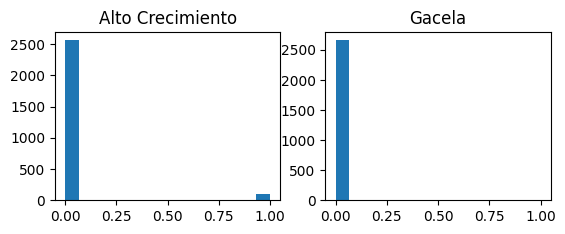

In [ ]:
plt.subplot(2,2,1)
plt.hist(df2['ALTO_CRECIMIENTO_CALCU'], bins = 15)
plt.title('Alto Crecimiento')

plt.subplot(2,2,2)
plt.hist(df2['GACELA_CALCU'], bins = 15)
plt.title('Gacela')

Además, tenemos que recalcular los registros que sirven para el modelo, los cuales son los que tienen más de 3 balances

In [ ]:
modelo_calc=[]
for i in range(len(df2)):
  if df2.iloc[i]['Bal1']==1 and df2.iloc[i]['Bal2'] == 1 and df2.iloc[i]['Bal3']==1 and df2.iloc[i]['Bal4']==1: 
    modelo_calc.append(1)
  else:
    modelo_calc.append(0)
df2['MODELO_CALCU']=modelo_calc

In [ ]:
print('Numero de empresas del modelo: ', len(df2[df2['MODELO_CALCU']==1]))

Numero de empresas del modelo:  1350


Una vez tenemos lo anterior, el número de balances no nos interesa, por lo que procedemos a borrarlos

In [ ]:
df2.drop(columns=['Bal1', 'Bal2', 'Bal3', 'Bal4', 'NUM_BALANCES', 'ESTUDIOPRED', 'MODELO'], axis=1, inplace=True)

###Descripción de los datos

Lo primero que vamos a hacer va a ser pasar la fecha del Inicio de la Actividad y del Último Acto Mercantil Registrado al año, es decir, eliminar el dia y el mes y quedarnos con el año

<Axes: xlabel='Inicio Actividad', ylabel='Count'>

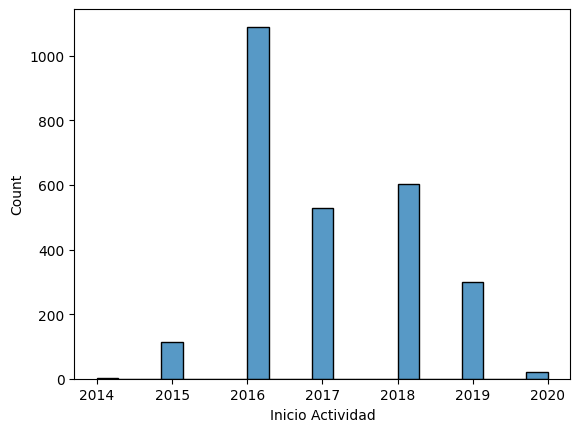

In [ ]:
df2['Inicio Actividad'] = df2['InicioActividad'].dt.year
df2.drop(columns=['InicioActividad'], inplace=True, axis=1)
sns.histplot(x = "Inicio Actividad", data = df2)

<Axes: xlabel='ULT_ACTOMERCANTIL_Y', ylabel='Count'>

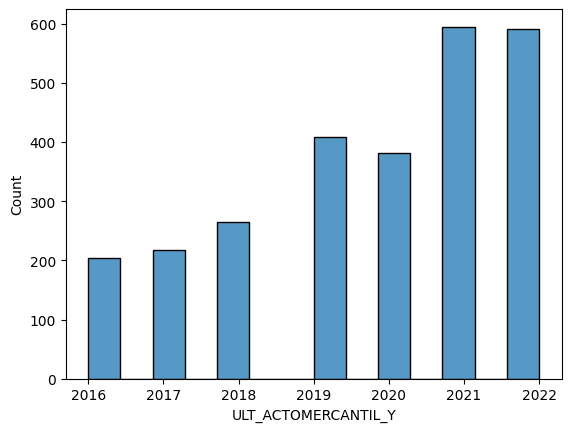

In [ ]:
df2['ULT_ACTOMERCANTIL_Y'] = df2['ULT_ACTOMERCANTIL'].dt.year
df2.drop(columns=['ULT_ACTOMERCANTIL'], inplace=True, axis=1)
sns.histplot(x = "ULT_ACTOMERCANTIL_Y", data = df2)

A continuación, antes de preparar los datos para el modelo, vamos a realizar un análisis de los mismos.

####Datos Numéricos

In [ ]:
stats_df = df2.describe()
# Obtener y añadir la mediana
median = pd.DataFrame(df2.median())
median = median.transpose()
median.rename(index = {0:'median'},inplace = True)
stats_df = stats_df.append(median).transpose() 
stats_df

<ipython-input-39-ab622b5945eb>:3: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  median = pd.DataFrame(df2.median())
<ipython-input-39-ab622b5945eb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append(median).transpose()


,count,mean,std,min,25%,50%,75%,max,median
ID,2661.0,1.114893e+05,6.351747e+03,1.000170e+05,105210.000000,111975.000000,115536.000000,1.226850e+05,111975.000000
CNAE,2661.0,5.524034e+03,1.668606e+03,1.610000e+02,4771.000000,6201.000000,6209.000000,9.609000e+03,6201.000000
ACC_EXTRAN,122.0,1.155738e+00,3.641018e-01,1.000000e+00,1.000000,1.000000,1.000000,2.000000e+00,1.000000
ACC_EMPRESA,770.0,1.585714e+00,1.148778e+00,1.000000e+00,1.000000,1.000000,2.000000,8.000000e+00,1.000000
NUMACCIONISTAS,1468.0,1.797003e+00,1.941810e+00,1.000000e+00,1.000000,1.000000,2.000000,2.400000e+01,1.000000
CARGOS_ADMIN,2657.0,2.521265e+00,2.760048e+00,1.000000e+00,1.000000,1.000000,3.000000,3.500000e+01,1.000000
codPostal,2661.0,2.691454e+04,1.303173e+04,1.006000e+03,15705.000000,28042.000000,35260.000000,5.066000e+04,28042.000000
AÑO CONCESION,2649.0,2.018744e+03,1.218249e+00,2.012000e+03,2018.000000,2019.000000,2020.000000,2.021000e+03,2019.000000
IMPORTE NOMINAL,2650.0,9.800988e+04,7.864519e+05,6.480000e+01,4448.882500,15000.000000,69352.500000,3.632484e+07,15000.000000
VENTAS_4,1371.0,3.991772e+02,1.808831e+03,0.000000e+00,0.000000,1.000000,226.000000,3.559400e+04,1.000000


In [ ]:
corr2 = df2.corr(method='pearson')
corr2[['ALTO_CRECIMIENTO_CALCU']].sort_values(by = 'ALTO_CRECIMIENTO_CALCU',ascending = False)\
.style.background_gradient()

<ipython-input-40-c8a725e1708a>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr2 = df2.corr(method='pearson')


,ALTO_CRECIMIENTO_CALCU
ALTO_CRECIMIENTO_CALCU,1.000000
diff_ventas_34,0.251693
MODELO_CALCU,0.193715
diff_activo_34,0.100483
diff_pasivo_34,0.100482
GACELA_CALCU,0.098635
VENTAS_4,0.072764
ID,0.033945
diff_pasivo_23,0.028051
ULT_ACTOMERCANTIL_Y,0.027712


In [ ]:
corr2.to_csv('corr_Abuelos_altoCrec.csv')

In [ ]:
corr2 = df2.corr(method='pearson')
corr2[['VENTAS_4']].sort_values(by = 'VENTAS_4',ascending = False)\
.style.background_gradient()

<ipython-input-42-d8ccabbb145d>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr2 = df2.corr(method='pearson')


,VENTAS_4
VENTAS_4,1.000000
CARGOS_ADMIN,0.240676
EMP_3,0.199097
EMP_2,0.198356
diff_ventas_34,0.157575
EMP_1,0.156381
EMP_4,0.119562
diff_activo_12,0.094387
diff_pasivo_12,0.094379
END_1,0.086174


In [ ]:
corr2.to_csv('corr_Abuelos_ventas.csv')

####Datos categóricos

In [ ]:
df2.describe(include='object').T

,count,unique,top,freq
CNAE_DESCRIPCION,2661,174,Actividades de programación informática,341
IMPORT_EXPORT,2661,4,Nada,2334
TAM_EMPRESA,2661,5,Microempresa,2251
Estado,2661,2,Viva,2660
INFO_ADMIN,2661,1,SI,2661
ACT_MEDIOS,1230,3,Activa en Redes,706
ESTRUCTURA,33,2,Cabecera Grupo Consolidado,19
MUJERES_CONSEJO,2661,2,NO,2267
frmJuridica,2661,3,B,2497
DESCRIPCIÓN,2649,768,REAFIANZAMIENTO DEL PROGRAMA DE AVALES PARA PY...,113


Empresas de alto crecimiento

In [ ]:
alt_crec=df2[df2['ALTO_CRECIMIENTO_CALCU']==1]
alt_crec.describe(include='object').T

,count,unique,top,freq
CNAE_DESCRIPCION,99,19,Fabricación de otra maquinaria para usos espec...,13
IMPORT_EXPORT,99,3,Nada,83
TAM_EMPRESA,99,2,Microempresa,90
Estado,99,1,Viva,99
INFO_ADMIN,99,1,SI,99
ACT_MEDIOS,59,3,Activa en Redes,39
ESTRUCTURA,0,0,NaN,NaN
MUJERES_CONSEJO,99,2,NO,95
frmJuridica,99,1,B,99
DESCRIPCIÓN,98,79,REAFIANZAMIENTO DEL PROGRAMA DE AVALES PARA PY...,5


In [ ]:
gacela=df2[df2['GACELA_CALCU']==1]
gacela.describe(include='object').T

,count,unique,top,freq
CNAE_DESCRIPCION,1,1,Actividades de programación y emisión de telev...,1
IMPORT_EXPORT,1,1,Nada,1
TAM_EMPRESA,1,1,Pequeña,1
Estado,1,1,Viva,1
INFO_ADMIN,1,1,SI,1
ACT_MEDIOS,0,0,NaN,NaN
ESTRUCTURA,0,0,NaN,NaN
MUJERES_CONSEJO,1,1,NO,1
frmJuridica,1,1,B,1
DESCRIPCIÓN,1,1,"FOMENTO DE LA CULTURA CIENTÍFICA, TECNOLÓGICA ...",1


##**NIETOS**

In [3]:
activo.drop(columns=['B-AC_2020', 'B-AC_2019', 'B-AC_2018', 'B-AC_2017', 'B-AC_2016', 'A-ANC_2020', 'A-ANC_2019', 'A-ANC_2018', 'A-ANC_2017', 'A-ANC_2016',
                     'TOT_ACTIVO_A_B_2020', 'TOT_ACTIVO_A_B_2019', 'TOT_ACTIVO_A_B_2018', 'TOT_ACTIVO_A_B_2017', 'TOT_ACTIVO_A_B_2016'], axis=1, inplace=True)
pasivo.drop(columns=['C-PC_2020', 'C-PC_2019', 'C-PC_2018', 'C-PC_2017', 'C-PC_2016', 'B-PNC_2020', 'B-PNC_2019', 'B-PNC_2018', 'B-PNC_2017', 'B-PNC_2016', 
                     'A-PN_2020', 'A-PN_2019', 'A-PN_2018', 'A-PN_2017', 'A-PN_2016', 'TOT_PN_PASIVO_2020', 'TOT_PN_PASIVO_2019', 'TOT_PN_PASIVO_2018', 
                     'TOT_PN_PASIVO_2017', 'TOT_PN_PASIVO_2016'], inplace=True, axis=1)
CR.drop(columns=['A1-RES_EXPLO_2016', 'A1-RES_EXPLO_2017', 'A1-RES_EXPLO_2018', 'A1-RES_EXPLO_2019', 'A1-RES_EXPLO_2020', 'A2-RES_FINAN_2016',
                 'A2-RES_FINAN_2017', 'A2-RES_FINAN_2018', 'A2-RES_FINAN_2019', 'A2-RES_FINAN_2020', 'A3-RES_AI_2016', 'A3-RES_AI_2017', 'A3-RES_AI_2018', 
                 'A3-RES_AI_2019', 'A3-RES_AI_2020', 'RES_EJERC_2016', 'RES_EJERC_2017', 'RES_EJERC_2018', 'RES_EJERC_2019', 'RES_EJERC_2020'], 
                  axis=1, inplace=True )

combinamos los datasets de activo-pasivo-CR

In [4]:
activo_pasivo_CR=activo.merge(pasivo, on='ID').merge(CR, on='ID')

Vemos si hay registros duplicados

In [5]:
#vemos si hay registros duplicados
if datos.duplicated().any():
  print('datos yes')
if ratios.duplicated().any():
  print('ratios yes')
if subvenciones.duplicated().any():
  print('subvenciones yes')
if activo_pasivo_CR.duplicated().any():
  print('activo_pasivo_CR yes')

subvenciones yes


Eliminamos registros duplicados

In [6]:
#eliminamos los duplicados
subvenciones=subvenciones.drop_duplicates()

Combinamos los datasets

In [7]:
df_nietos = datos.merge(ratios,on='ID').merge(subvenciones,on='ID').merge(activo_pasivo_CR, on='ID')
df_nietos.head()

,ID,CNAE,CNAE_DESCRIPCION,IMPORT_EXPORT,ULT_ACTOMERCANTIL,TAM_EMPRESA,Estado,ACC_EXTRAN,ACC_EMPRESA,NUMACCIONISTAS,...,A-17-DIF_CAMBIO_2020,A-17-DIF_CAMBIO_2019,A-17-DIF_CAMBIO_2018,A-17-DIF_CAMBIO_2017,A-17-DIF_CAMBIO_2016,A-20-IMPUESTOS_2020,A-20-IMPUESTOS_2019,A-20-IMPUESTOS_2018,A-20-IMPUESTOS_2017,A-20-IMPUESTOS_2016
0,100017,7219,Otra investigación y desarrollo experimental e...,Nada,2020-12-14 01:00:00,Microempresa,Viva,NaN,NaN,NaN,...,0,0,0,0,0,7,33,27,0,0
1,100017,7219,Otra investigación y desarrollo experimental e...,Nada,2020-12-14 01:00:00,Microempresa,Viva,NaN,NaN,NaN,...,0,0,0,0,0,7,33,27,0,0
2,100017,7219,Otra investigación y desarrollo experimental e...,Nada,2020-12-14 01:00:00,Microempresa,Viva,NaN,NaN,NaN,...,0,0,0,0,0,7,33,27,0,0
3,100020,2822,Fabricación de maquinaria de elevación y manip...,Nada,2019-02-04 01:00:00,Pequeña,Viva,NaN,NaN,1.0,...,0,0,0,0,0,-302,-330,-198,0,0
4,100020,2822,Fabricación de maquinaria de elevación y manip...,Nada,2019-02-04 01:00:00,Pequeña,Viva,NaN,NaN,1.0,...,0,0,0,0,0,-302,-330,-198,0,0


###Cambiar años naturales por años de vida de startup

In [8]:
df_nietos.drop(columns=['VENTAS_FINAL', 'CREC20192020', 'CREC20182019', 'CREC20172018', 'CREC20162017', 'GACELA20192020', 'GACELA20182019', 
                 'GACELA20172018', 'GACELA20162017', 'VENTAS_2016', 'VENTAS_2017', 'VENTAS_2018', 'VENTAS_2019', 'VENTAS_2020'], axis=1, inplace=True)
#Eliminamos las ventas porque están en el df de Activo

In [9]:
nuevas_columnas=[]
columnas=list(df_nietos.columns)
for col in columnas:
  if '2016' in col:
    col1=col.replace('2016', '1')
    nuevas_columnas.append(col1)
  if '2017' in col:
    col2=col.replace('2017', '2')
    nuevas_columnas.append(col2)
  if '2018' in col:
    col3=col.replace('2018', '3')
    nuevas_columnas.append(col3)
  if '2019' in col:
    col4=col.replace('2019', '4')
    nuevas_columnas.append(col4)
  if '2020' in col:
    col5=col.replace('2020', '5')
    nuevas_columnas.append(col5)

for nc in nuevas_columnas:
  df_nietos[nc]=np.nan

<ipython-input-9-7683e4e9a22b>:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_nietos[nc]=np.nan
<ipython-input-9-7683e4e9a22b>:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_nietos[nc]=np.nan
<ipython-input-9-7683e4e9a22b>:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_nietos[nc]=np

Cambiamos los años naturales por los años relativos al número de balances

In [10]:
for i in range(0,len(df_nietos)):
  if df_nietos['Bal2016'][i]==1:
    for col in list(df_nietos.columns):
      if '2016' in col:
        col1=col.replace('2016', '1')
        df_nietos[col1][i]=df_nietos[col][i]
      if '2017' in col:
        col2=col.replace('2017', '2')
        df_nietos[col2][i]=df_nietos[col][i]
      if '2018' in col:
        col3=col.replace('2018', '3')
        df_nietos[col3][i]=df_nietos[col][i]
      if '2019' in col:
        col4=col.replace('2019', '4')
        df_nietos[col4][i]=df_nietos[col][i]
      if '2020' in col:
        col5=col.replace('2020', '5')
        df_nietos[col5][i]=df_nietos[col][i]
  elif df_nietos['Bal2017'][i]==1:
    for col in list(df_nietos.columns):
      if '2017' in col:
        col2=col.replace('2017', '1')
        df_nietos[col2][i]=df_nietos[col][i]
      if '2018' in col:
        col3=col.replace('2018', '2')
        df_nietos[col3][i]=df_nietos[col][i]
      if '2019' in col:
        col4=col.replace('2019', '3')
        df_nietos[col4][i]=df_nietos[col][i]
      if '2020' in col:
        col5=col.replace('2020', '4')
        df_nietos[col5][i]=df_nietos[col][i]
  elif df_nietos['Bal2018'][i]==1:
    for col in list(df_nietos.columns):
      if '2018' in col:
        col3=col.replace('2018', '1')
        df_nietos[col3][i]=df_nietos[col][i]
      if '2019' in col:
        col4=col.replace('2019', '2')
        df_nietos[col4][i]=df_nietos[col][i]
      if '2020' in col:
        col5=col.replace('2020', '3')
        df_nietos[col5][i]=df_nietos[col][i]
  elif df_nietos['Bal2019'][i]==1:
    for col in list(df_nietos.columns):
      if '2019' in col:
        col4=col.replace('2019', '1')
        df_nietos[col4][i]=df_nietos[col][i]
      if '2020' in col:
        col5=col.replace('2020', '2')
        df_nietos[col5][i]=df_nietos[col][i]
  elif df_nietos['Bal2020'][i]==1:
    for col in list(df_nietos.columns):
      if '2020' in col:
        col5=col.replace('2020', '1')
        df_nietos[col5][i]=df_nietos[col][i]

<ipython-input-10-e1a64668a4a1>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nietos[col5][i]=df_nietos[col][i]
<ipython-input-10-e1a64668a4a1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nietos[col4][i]=df_nietos[col][i]
<ipython-input-10-e1a64668a4a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nietos[col3][i]=df_nietos[col][i]
<ipython-input-10-e1a64668a4a1>:9: SettingWithCopyWarning: 
A value is trying to b

Eliminamos las columnas de años naturales

In [11]:
eliminar=[]

for col in df_nietos.columns:
  if '2016' in col:
    eliminar.append(col)
  elif '2017' in col:
    eliminar.append(col)
  elif '2018' in col:
    eliminar.append(col)
  elif '2019' in col:
    eliminar.append(col)
  elif '2020' in col:
    eliminar.append(col) 

df_nietos.drop(columns=eliminar, axis=1, inplace=True)

Las startups con más de 3 años de vida las vamos a separar en registros de 3. Es decir, si una empresa tiene 4 años de vida, vamos a tener un registro con los años 1, 2 y 3; y otro registro con los años 2, 3 y 4.

Para ello hacemos 2 nuevos datasets, uno de 4 años y otro de 5 y realizamos las replicas sobre estos dos nuevos datasets para unirlos al original de forma posterior

In [12]:
df_nietos_5=df_nietos[df_nietos['NUM_BALANCES']==5]

eliminar=[]
for col in df_nietos_5:
  if '_1' in col:
    eliminar.append(col)

df_nietos_5.drop(columns=eliminar, axis=1, inplace=True)

rename_cols={}
for col in df_nietos_5:
  if '_2' in col:
    col1=col.replace('_2', '_1')
    rename_cols[col]=col1
  if '_3' in col:
    col2=col.replace('_3', '_2')
    rename_cols[col]=col2
  if '_4' in col:
    col3=col.replace('_4', '_3')
    rename_cols[col]=col3
  if '_5' in col:
    col4=col.replace('_5', '_4')
    rename_cols[col]=col4

df_nietos_5=df_nietos_5.rename(columns=rename_cols)

<ipython-input-12-318ed43b41be>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nietos_5.drop(columns=eliminar, axis=1, inplace=True)


Eliminamos los años 5 del dataset original y unimos los dos

In [13]:
#primero eliminamos los años 5 del dataset original
eliminar=[]
for col in df_nietos:
  if '_5' in col:
    eliminar.append(col)
df_nietos.drop(columns=eliminar, axis=1, inplace=True)

#Unimos los datasets
frames = [df_nietos, df_nietos_5]
df_nietos2 = pd.concat(frames)


In [14]:
df_nietos2 = df_nietos2.reset_index()
df_nietos2.drop(columns=['index'], axis=1, inplace=True)

In [15]:
df_nietos2.head()

,ID,CNAE,CNAE_DESCRIPCION,IMPORT_EXPORT,ULT_ACTOMERCANTIL,TAM_EMPRESA,Estado,ACC_EXTRAN,ACC_EMPRESA,NUMACCIONISTAS,...,A-15-GAS_FIN_2,A-15-GAS_FIN_1,A-17-DIF_CAMBIO_4,A-17-DIF_CAMBIO_3,A-17-DIF_CAMBIO_2,A-17-DIF_CAMBIO_1,A-20-IMPUESTOS_4,A-20-IMPUESTOS_3,A-20-IMPUESTOS_2,A-20-IMPUESTOS_1
0,100017,7219,Otra investigación y desarrollo experimental e...,Nada,2020-12-14 01:00:00,Microempresa,Viva,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,33.0,27.0,0.0,0.0
1,100017,7219,Otra investigación y desarrollo experimental e...,Nada,2020-12-14 01:00:00,Microempresa,Viva,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,33.0,27.0,0.0,0.0
2,100017,7219,Otra investigación y desarrollo experimental e...,Nada,2020-12-14 01:00:00,Microempresa,Viva,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,33.0,27.0,0.0,0.0
3,100020,2822,Fabricación de maquinaria de elevación y manip...,Nada,2019-02-04 01:00:00,Pequeña,Viva,NaN,NaN,1.0,...,-3.0,-3.0,NaN,0.0,0.0,0.0,NaN,-302.0,-330.0,-198.0
4,100020,2822,Fabricación de maquinaria de elevación y manip...,Nada,2019-02-04 01:00:00,Pequeña,Viva,NaN,NaN,1.0,...,-3.0,-3.0,NaN,0.0,0.0,0.0,NaN,-302.0,-330.0,-198.0


Pasamos los datos a evoluciones, ya que dependiendo de la empresa está tendrá diferentes resultados y las evoluciones son más comunes a todas. 

In [16]:
for col in df_nietos2:
  if '_1' in col:
    col2=col.replace('_1', '_2')
    col3=col.replace('_1', '_12_diff')
    df_nietos2[col3]= (df_nietos2[col2]/df_nietos2[col])-1
  if '_2' in col:
    col2=col.replace('_2', '_3')
    col3=col.replace('_2', '_23_diff')
    df_nietos2[col3]=(df_nietos2[col2]/df_nietos2[col])-1
  if '_3' in col:
    col2=col.replace('_3', '_4')
    col3=col.replace('_3', '_34_diff')
    df_nietos2[col3]=(df_nietos2[col2]/df_nietos2[col])-1


<ipython-input-16-55cc7aabc0f9>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_nietos2[col3]= (df_nietos2[col2]/df_nietos2[col])-1
<ipython-input-16-55cc7aabc0f9>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_nietos2[col3]=(df_nietos2[col2]/df_nietos2[col])-1
<ipython-input-16-55cc7aabc0f9>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

Vemos si hay mayor correlación con los valores enteros o con las diferencias

In [ ]:
corr_nietos = df_nietos2.corr(method='pearson')
corr_nietos[['ALTO_CRECIMIENTO']].sort_values(by = 'ALTO_CRECIMIENTO',ascending = False)\
.style.background_gradient()

<ipython-input-61-db2ebc7920e9>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_nietos = df_nietos2.corr(method='pearson')


,ALTO_CRECIMIENTO
ALTO_CRECIMIENTO,1.000000
C-VI-PER_CP_12_diff,0.987243
C-VI-PER_CP_23_diff,0.860627
B-I-PROV_LP_3,0.825356
A-IV-INV_GRU_12_diff,0.537481
B-III-DEU_GRU_LP_12_diff,0.461229
A-15-GAS_FIN_12_diff,0.313171
A-5-OTROSINGRESOS_23_diff,0.290639
A-IV-INV_GRU_23_diff,0.287652
EMP_23_diff,0.282108


Ahora añadimos una columna que especifica si la empresa ha recibido una subvención

In [17]:
subvencion=[]
for i in df_nietos2['IMPORTE NOMINAL']:
  if i>0:
    subvencion.append(1)
  else:
    subvencion.append(0)
df_nietos2['Subvencion']=subvencion

<ipython-input-17-5cb4b1051323>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_nietos2['Subvencion']=subvencion


A continuación vamos a eliminar las columnas de Gacela calculado y de Alto crecimiento y vamos a crear dos columnas nuevas con estos datos, ya que hay registros que hemos separado en 2 y los datos anteriores no son exactos

In [18]:
alto_crec_calcu=[]
for i in range(len(df_nietos2)):
  if df_nietos2.iloc[i]['A-1-VENTAS_12_diff'] >= 0.2 and df_nietos2.iloc[i]['A-1-VENTAS_23_diff']>=0.2 and df_nietos2.iloc[i]['A-1-VENTAS_34_diff']>=0.2:
    alto_crec_calcu.append(1)
  else:
    alto_crec_calcu.append(0)
df_nietos2['ALTO_CRECIMIENTO_CALCU']=alto_crec_calcu

<ipython-input-18-8871d49cd67c>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_nietos2['ALTO_CRECIMIENTO_CALCU']=alto_crec_calcu


In [19]:
gacela=[]
for i in range(len(df_nietos2)):
  if df_nietos2.iloc[i]['EMP_1']>=10 and df_nietos2.iloc[i]['A-1-VENTAS_4'] >= 500 and df_nietos2.iloc[i]['ALTO_CRECIMIENTO_CALCU']==1: #ventas estan en miles de €
    gacela.append(1)
  else:
    gacela.append(0)
df_nietos2['GACELA_CALCU']=gacela

<ipython-input-19-36a865030639>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_nietos2['GACELA_CALCU']=gacela


Eliminamos las columnas anteriores de alto crecimiento y gacela. También se va a eliminar la columna de empleados al inicio ya que en este caso los empleados que nos interesan son los del año1 

In [20]:
df_nietos2.drop(columns=['ALTO_CRECIMIENTO', 'GACELA_CALCULADO', 'EMP_INICIO'], axis=1, inplace=True)

Como se puede observar hay mayor correlación con las diferencias, por lo que eliminamos los valores enteros exceptuando el año 1
Además vamos a eliminar las columnas con valores enteros (excepto el año 1) ya que la correlación es mayor con las diferencias

In [21]:
#Renombramos el campo de Ventas_4 como ventas_final para el modelo de regresión
df_nietos2.rename(columns={"A-1-VENTAS_4": "VENTAS_FINAL"}, inplace=True)

In [22]:
eliminar=[]

for col in df_nietos2:
  if '_2' in col and not 'diff' in col and not 'VENTAS' in col:
    eliminar.append(col)
  if '_3' in col and not 'diff' in col and not 'VENTAS' in col:
    eliminar.append(col)
  if '_4' in col and not 'diff' in col and not 'VENTAS' in col:
    eliminar.append(col)
df_nietos2.drop(columns=eliminar, axis=1, inplace=True)

Text(0.5, 1.0, 'Gacela')

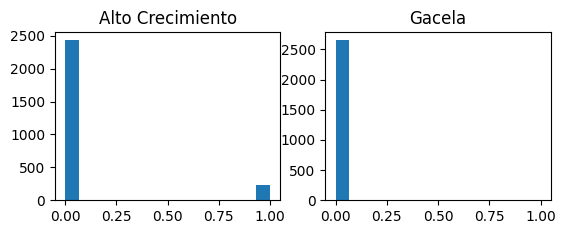

In [23]:
plt.subplot(2,2,1)
plt.hist(df_nietos2['ALTO_CRECIMIENTO_CALCU'], bins = 15)
plt.title('Alto Crecimiento')

plt.subplot(2,2,2)
plt.hist(df_nietos2['GACELA_CALCU'], bins = 15)
plt.title('Gacela')

In [24]:
print('Numero de empresas alto crecimiento: ', len(df_nietos2[df_nietos2['ALTO_CRECIMIENTO_CALCU']==1]))
print('Numero de empresas gacela: ', len(df_nietos2[df_nietos2['GACELA_CALCU']==1]))

Numero de empresas alto crecimiento:  231
Numero de empresas gacela:  10


Por otro lado también tenemos que recalcular los registros que sirven para el modelo, es decir, aquellos que tienen más de 3 balances

In [25]:
modelo_calc=[]
for i in range(len(df_nietos2)):
  if df_nietos2.iloc[i]['Bal1']==1 and df_nietos2.iloc[i]['Bal2'] == 1 and df_nietos2.iloc[i]['Bal3']==1 and df_nietos2.iloc[i]['Bal4']==1: 
    modelo_calc.append(1)
  else:
    modelo_calc.append(0)
df_nietos2['MODELO_CALCU']=modelo_calc

In [26]:
print('Numero de empresas del modelo: ', len(df_nietos2[df_nietos2['MODELO_CALCU']==1]))

Numero de empresas del modelo:  1350


Una vez tenemos lo anterior, el número de balances no nos interesa, por lo que procedemos a borrarlos. 

In [27]:
df_nietos2.drop(columns=['Bal1', 'Bal2', 'Bal3', 'Bal4', 'NUM_BALANCES', 'ESTUDIOPRED', 'MODELO'], axis=1, inplace=True)

In [28]:
df_nietos2.head()

,ID,CNAE,CNAE_DESCRIPCION,IMPORT_EXPORT,ULT_ACTOMERCANTIL,TAM_EMPRESA,Estado,ACC_EXTRAN,ACC_EMPRESA,NUMACCIONISTAS,...,A-17-DIF_CAMBIO_34_diff,A-17-DIF_CAMBIO_23_diff,A-17-DIF_CAMBIO_12_diff,A-20-IMPUESTOS_34_diff,A-20-IMPUESTOS_23_diff,A-20-IMPUESTOS_12_diff,Subvencion,ALTO_CRECIMIENTO_CALCU,GACELA_CALCU,MODELO_CALCU
0,100017,7219,Otra investigación y desarrollo experimental e...,Nada,2020-12-14 01:00:00,Microempresa,Viva,NaN,NaN,NaN,...,NaN,NaN,NaN,0.222222,inf,NaN,1,0,0,1
1,100017,7219,Otra investigación y desarrollo experimental e...,Nada,2020-12-14 01:00:00,Microempresa,Viva,NaN,NaN,NaN,...,NaN,NaN,NaN,0.222222,inf,NaN,1,0,0,1
2,100017,7219,Otra investigación y desarrollo experimental e...,Nada,2020-12-14 01:00:00,Microempresa,Viva,NaN,NaN,NaN,...,NaN,NaN,NaN,0.222222,inf,NaN,1,0,0,1
3,100020,2822,Fabricación de maquinaria de elevación y manip...,Nada,2019-02-04 01:00:00,Pequeña,Viva,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,-0.084848,0.666667,1,0,0,0
4,100020,2822,Fabricación de maquinaria de elevación y manip...,Nada,2019-02-04 01:00:00,Pequeña,Viva,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,-0.084848,0.666667,1,0,0,0


Guardamos el dataframe

In [29]:
df_nietos2.to_csv('df_nietos2.csv')